In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
raw_folder = "/content/drive/MyDrive/data/"
def save_data(raw_folder=raw_folder):

    dest_size = (128, 128)
    print("Bắt đầu xử lý ảnh...")

    pixels = []
    labels = []

    # Lặp qua các folder con trong thư mục raw
    for folder in listdir(raw_folder):
        if folder!='.DS_Store':
            print("Folder=",folder)
            # Lặp qua các file trong từng thư mục chứa các em
            for file in listdir(raw_folder  + folder):
                if file!='.DS_Store':
                    print("File=", file)
                    pixels.append( cv2.resize(cv2.imread(raw_folder  + folder +"/" + file),dsize=(128,128)))
                    labels.append( folder)

    pixels = np.array(pixels)
    labels = np.array(labels).reshape(-1,1)

    from sklearn.preprocessing import LabelBinarizer
    encoder = LabelBinarizer()
    labels = encoder.fit_transform(labels)
    print(labels)

    file = open('pix.data', 'wb')
    # dump information to that file
    pickle.dump((pixels,labels), file)
    # close the file
    file.close()

    return

def load_data():
    file = open('pix.data', 'rb')

    # dump information to that file
    (pixels, labels) = pickle.load(file)

    # close the file
    file.close()

    print(pixels.shape)
    print(labels.shape)


    return pixels, labels

save_data()
X,y = load_data()
#random.shuffle(X)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=100)

print(X_train.shape)
print(y_train.shape)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]
(3000, 128, 128, 3)
(3000, 3)
(2400, 128, 128, 3)
(2400, 3)


In [ ]:


def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    # Dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    # Tao model
    input = Input(shape=(128, 128, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    # Them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dense(1024, activation='relu', name='fc2')(x)
    x = Dense(3, activation='softmax', name='predictions')(x)

    # Compile
    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    my_model.optimizer.learning_rate = 0.001

    return my_model

vggmodel = get_model()










58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vggmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 fc1 (Dense)                 (None, 1024)              8389632   
                                                                 
 fc2 (Dense)                 (None, 1024)              1049600   
                                                                 
 predictions (Dense)         (None, 3)                 3075      
                                                                 
Total params: 24,156,995
Trainable params: 9,442,307
Non-trai

In [ ]:
filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
    rescale=1./255,
	width_shift_range=0.1,
    height_shift_range=0.1,
	horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

aug_val = ImageDataGenerator(rescale=1./255)

vgghist=vggmodel.fit_generator(aug.flow(X_train, y_train,batch_size=64),
                               epochs=50, #steps_per_epoch=len(X_train)//64,
                               validation_data=aug.flow(X_test,y_test,batch_size=64
                               ),
                               callbacks=callbacks_list)

vggmodel.save("vggmodel.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.8745 - accuracy: 0.7454
Epoch 1: val_accuracy improved from -inf to 0.92167, saving model to weights-01-0.92.hdf5
38/38 [==============================] - 26s 453ms/step - loss: 0.8745 - accuracy: 0.7454 - val_loss: 0.6673 - val_accuracy: 0.9217
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.9458
Epoch 2: val_accuracy improved from 0.92167 to 0.96167, saving model to weights-02-0.96.hdf5
38/38 [==============================] - 14s 363ms/step - loss: 0.5557 - accuracy: 0.9458 - val_loss: 0.4697 - val_accuracy: 0.9617
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.9688
Epoch 3: val_accuracy improved from 0.96167 to 0.97333, saving model to weights-03-0.97.hdf5
38/38 [==============================] - 14s 360ms/step - loss: 0.4080 - accuracy: 0.9688 - val_loss: 0.3451 - val_accuracy: 0.9733
Epoch 4/50
38/38 [============================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


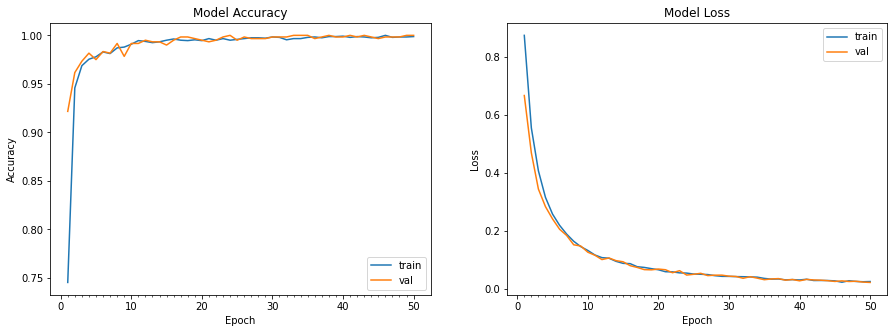

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    #plt.show()
    plt.savefig('roc.png')
plot_model_history(vgghist)